#Rainbow: Combining Improvements in Deep Reinforcement Learning
**Author:Mithuran Gajendran, Nabil Madali**

#Introduction
After DQN was first proposed in 2013, Researchers have made many improvements to it, six of which are the most important ones:

**Double-DQN**: Separate action selection from value estimation to avoid overestimation

**Dueling-DQN**: Decompose Q value into state value and advantage function to get more useful information

**Prioritized Replay Buffer**: Sampling experience in the experience pool according to priority

**Multi-Step Learning**: Make target value estimates more accurate
Distributional DQN (Categorical DQN): get value distribution

**NoisyNet**: Enhanced Model Discovery

Recently, in the paper "**Rainbow: Combining Improvements in Deep Reinforcement Learning**", DeepMind integrated these six methods and proposed the Rainbow model. In this article, let's review DQN and its various improved models.



## Original DQN

Q-learning is a very important off-policy learning method in reinforcement learning. It uses Q-Table to store the value of each state action pair. When the state and action space are high-dimensional or continuous, Q-Table is used. Unrealistic.

Therefore, turning the Q-Table update problem into a function fitting problem, using a neural network to get the Q value of the state action, and updating the parameter θ to approximate the Q function to the optimal Q value, this is the basic idea of ​​DQN.

However, combining deep neural networks and reinforcement learning ideas will inevitably lead to certain problems, such as:

1. DL needs a large number of labeled samples for supervised learning; RL has only the return value of reward;

2. The sample of DL is independent; the state status of RL is related to that of RL;

3. The distribution of DL targets is fixed; the distribution of RL is always changing. For example, when you play a game, the status distribution of one level and the next level is different, so the previous level is trained, and the next level is retrained

4. Previous research shows that problems such as instability occur when using nonlinear networks to represent value functions.

To solve problem 1, we will use the Bellman equation:

$$q_\pi(s,a)=\mathbb{E}_\pi(R_{t+1}+\gamma q_\pi(S_{t+1},A_{t+1}) \mid S_{t+1}=s,A_{t+1}=a)$$ 

$$q_*(s,a)=R_{s}^{a} + \gamma \sum_{{s}'\in S  } P_{s{s}'} ^{a} max_{{a}'}q_*({s}',{a}')$$

The above two formulas, the first is the Bellman expectation equation and the second is the Bellman optimal equation. In our actual problem, for a state, take a specific action, and the next state is basically determined. , So we can remove the sum from the optimal equation. In this way, we can get an estimated value of Q through the neural network, and a target value of Q through the Bellman optimal equation, and carry out supervised learning through the gap between the estimated value and the target value.


In order to solve problems 2 and 3, we used the experience replay method. The specific method is to store the transfer samples ($s_t, a_t, r_t, s_{t+1}$, is_terminal) obtained by the agent interacting with the environment at each time step. In the experience pool, when you want to train, take out some minibatch to train. This avoids correlation issues.

Therefore, in DQN, the final loss function is as follows:

$$R_{t+1}+\gamma_{t+1}max_{{a}'}q_{\bar{\theta}}(S_{t+1},{a}'-q_{\theta}(S_t,A_t))^2$$

Among them, θ represents the parameters of eval-net, and θ represents the parameters of target-net. In practical applications, the parameters of target-net are copied from eval-net at regular intervals.




#Double-DQN
In the original DQN, there will be a situation where the Q value is estimated to be too high, because this is an off-policy strategy. Each time we learn, we do not use the real action used in the next interaction, but use the current strategy to think The value of the action is the largest, so there will be overestimation of the Q value. In DQN, we will also face the same problem, because we use the target-net when we choose the action at the next moment and calculate the state-action Q value at the next moment.

To decouple action selection and value estimation, we have the Double-DQN method. In Double-DQN, when calculating the actual value of Q, the action selection is obtained by eval-net, and the value estimate is obtained by target-net. At this point, the loss function becomes:

$$R_{t+1}+\gamma_{t+1}q_{\bar{\theta}}(S_{t+1},argmax_{{a}'}q_{\theta}(S_{t+1},{a}'))-q_{\theta}(S_{t},A_{t}))^2$$


## Prioritized Replay Buffer

In the traditional DQN experience pool, the selection of batch data for training is random, without considering the priority relationship of the samples. But in fact, the value of different samples is different, we need to give each sample a priority, and sample according to the priority of the sample.

How are the priorities of the samples determined? We can use TD-error, that is, q-target-q-eval to specify the degree of priority learning. If the TD-error is larger, it means that our prediction accuracy has a lot of room for improvement, then the more this sample needs to be Learning, that is, the higher the priority p.

With TD-error, we have the priority p, so how do we effectively sample according to p? If every sample needs to sort all samples for p, this will be a very computationally expensive thing. In the text A method called SumTree is proposed.

SumTree is a tree structure. The leaf node stores the priority p of each sample. Each branch node has only two forks. The value of the node is the sum of the two forks, so the top of the SumTree is the sum of all p. . As shown below. The lowermost layer of leaves stores the sample p, and the leftmost layer of the leaf is 13 = 3 + 10, and according to this rule, the top root is the sum of all p.




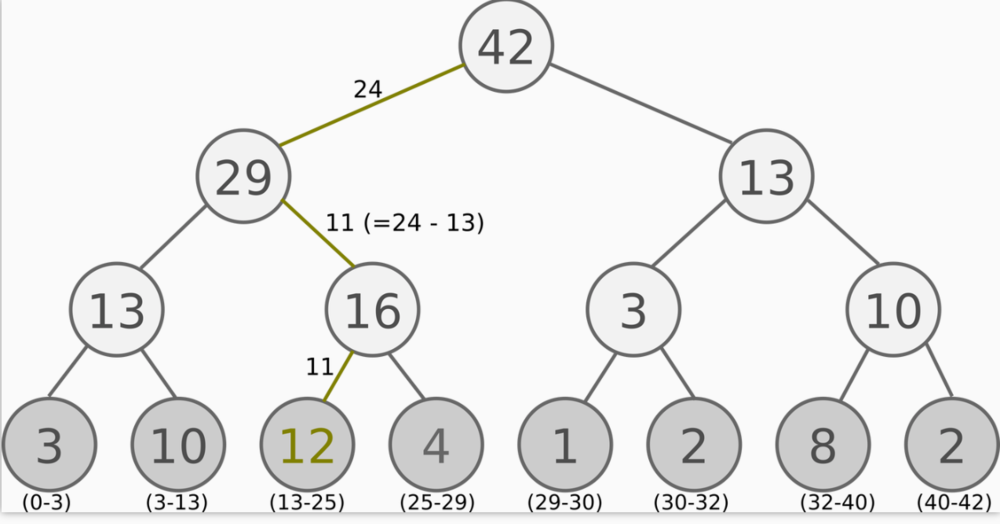

In [8]:
from IPython.display import Image
Image('plot1.png')

When sampling, we will divide the sum of p by the batch size, and divide it into batches of so many intervals, (n = sum (p) / batch_size). If the priority of all nodes is 42, if we take 6 samples The priority of the interval at this time may be like this.

[0-7], [7-14], [14-21], [21-28], [28-35], [35-42]

Then randomly select a number in each interval. For example, in the interval [21-28], 24 is selected, and then based on this 24, the search starts from the top 42. First see that there are two child nodes below the top 42. Take the 24 in your hand and compare it with the left child node, because 29> 24, then we go to the left; then compare the left child node 13 of 29 because 24> 13, then we go on the right, and modify the value in hand according to 13, to become 24-13 = 11. Then we take the left child node 12 of 11 and 13 and the result is 12 is larger than 11. Then we select the data corresponding to 12 as the result of sampling in this interval.

##Dueling-DQN
What is Dueling DQN? See the picture below

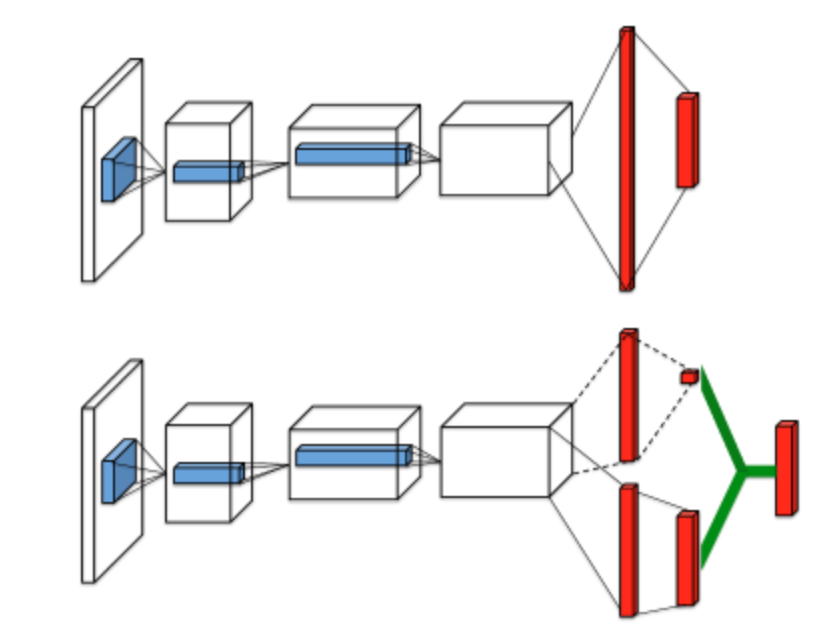

In [7]:
from IPython.display import Image
Image('plot2.png')

Above is our traditional DQN, below is our Dueling DQN. In the original DQN, the neural network directly outputs the Q value of each action, and the Q value of each action of Dueling DQN is determined by the state value V and the advantage function A, that is, Q = V + A.

What is the dominance function? We can simply understand that for a specific state, the value obtained by taking an action is different from the average value obtained by this state. If the action taken is greater than the average value, then the dominance function is positive, otherwise it is negative.

Is it simple to use Q = V + A? Of course not, because for a certain Q, there are countless combinations of V and A to get Q. Therefore, we need to limit A to some extent, and generally limit the mean value of the dominant function A to 0 in the same state. Therefore, our Q value calculation formula is as follows:
$$q_{\theta}(s,a)=v_\eta (f_\xi(s),a )-\frac{\sum_{{a}'}a_\psi (f_\xi(s),{a}')}{N_{actions}}$$

## Multi-Step Learning
The original DQN uses the current instant reward r and the value estimate of the next moment as the target value. This method has a large target value deviation when the previous strategy is poor, that is, the network parameter deviation is large, so learning The speed may be relatively slow. Therefore, we can solve this problem through Multi-Step Learning, so that the target value can be more accurately estimated in the early stage of training (because the instant reward can be accurately obtained through interaction with the environment), thereby speeding up the training speed.

In Multi-Step Learning, our loss function becomes:
$$R^{(n)}_t+\gamma^{(n)}_t max_{{a}'}q_{\bar{\theta}} (S_{t+n},{a}')-q_{\theta}(S_t,A_t))^2$$
$$R^{(n)}_t\equiv \sum_{k=0}^{n-1}\gamma^{(n)}_t R_{t+k+1}$$

## Distributional DQN
In DQN, the network outputs all the expected estimates of the state-action value Q. This expectation actually ignores a lot of information. For example, the two actions in the same state can have the same expected value. For example, both are 20. The first action is worth 10 in 90% of cases, and 110 in 10%. The other action is It is 15 in 50% of cases and 25 in 50% of cases. So although the expectations are the same, if we want to reduce the risk, we should choose the latter action. With only the expected value, we cannot see the risk behind the action.

So in theory, modeling our deep reinforcement learning model from a distributional perspective can get more useful information and thus get better and more stable results.

We choose a histogram to represent an estimate of the value distribution and limit the value to $[Vmin, Vmax]$. In $[Vmin, Vmax]$, select N equally spaced value sampling points. The output of the network is the probability of these N value sampling points.

Continuing the dual network structure in DQN, we will get the estimated value distribution and target value distribution (the target value distribution needs to be cropped and projected), and use the cross entropy loss function to calculate the gap between the two distributions, and pass The gradient descent method updates the parameters.

## NoisyNet

Increasing the agent's exploration ability is a problem often encountered in reinforcement learning. A commonly used method is to adopt the e-greedy strategy, that is, to take random actions with a probability of e, and take the currently obtained value with a probability of 1-e action. And another commonly used method is NoisyNet, which increases the model's exploration ability by adding noise to the parameters.

Our noise is usually added to the fully connected layer. Consider our forward calculation formula for the fully connected layer:

$$y=wx+b$$

Suppose the number of neurons in the two layers is p and q respectively, then w is q * p, x is p-dimensional, and y and b are q-dimensional.

At this time we add noise to the parameters. In the article, it is assumed that each parameter b and w obeys a normal distribution with mean μ and variance σ, and there is a certain random noise ε. We can assume that the noise obeys the standard normal. Distribution N (0,1). Then the forward calculation formula becomes:
$$y=(u^w+\sigma^w\odot \epsilon^w)x+u^b+\sigma^b\odot \epsilon^b,$$

In this way, the number of variables in our model has changed from the original p * q + q to 2 * p * q + q. You may ask, isn't the variable 3 * p * q + q? Because here, our noise ε is a randomly generated constant in each round. If the noise ε is also a variable, it is no different from the original wx + b.

The next question is how this noise is generated. Two methods are mentioned in the article:

Independent Gaussian noise: This is also the easiest method we can think of, which is to directly generate p * q + q constants directly from the standard normal distribution. This means that for each fully connected layer, independent noise is generated for each w and b, which undoubtedly brings a lot of burden to the calculation of the model.

Factorised Gaussian noise: This method effectively reduces the number of noises. We only need p + q noises. The noise of w and b is calculated as follows:
$$\epsilon_{i,j}^{w}=f(\epsilon_i)f(\epsilon_j)$$
$$\epsilon_{j}^{b}=f(\epsilon_j)$$

The function represented by f in the above formula is as follows:
$$f(x)=sgn(x)\sqrt{\mid x\mid }$$

Knowing how to add noise to the parameters, we can apply this method to methods such as DQN.



#Rainbow
Rainbow combines 6 recent advancements in reinforcement learning:

    N-step returns

    Distributional state-action value learning

    Dueling networks

    Noisy Networks

    Double DQN

    Prioritized Experience Replay
  
**Training the network**
1. Sample a batch of transitions from the replay buffer.
2. The Bellman update is projected to the set of atoms representing the 𝑄 values distribution, such that the 𝑖−𝑡ℎ component of the projected update is calculated as follows:


3. Network is trained with the cross entropy loss between the resulting probability distribution and the target probability distribution. Only the target of the actions that were actually taken is updated.

4. Once in every few thousand steps, weights are copied from the online network to the target network.

5. After every training step, the priorities of the batch transitions are updated in the prioritized replay buffer using the KL divergence loss that is returned from the network.

$$(\Phi \hat{T}Z_{\theta}(s_t,a_t))_i=\sum_{j=0}^{N-1}[1-\frac{\mid \hat{T_{z_j}}_{V_{min}}^{V_{max}}-z_j\mid }{\Delta z}]_{1}^{0}p_{j}(s_{t+1},\pi(s_{t+1}))$$
where: $*[.]$ bounds its argument in the range $[a,b]* \hat{T}_{z_j}$ is the Bellman update for atom $z_j$
$$\hat{T}_{z_j}=r_t+\gamma r_{t}+\gamma r_{t+1} +....+\gamma r_{n-1}+\gamma^{t+n-1} z_j  $$
 

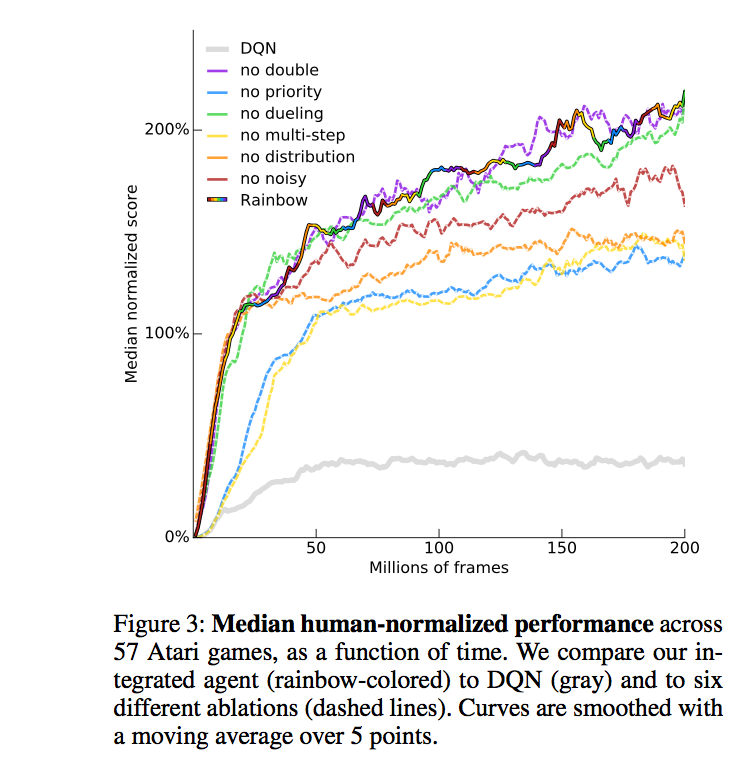

In [9]:
from IPython.display import Image
Image('plot3.png')

## References

1. 2013DQN：https://pdfs.semanticscholar.org/667f/b84bfca10bec165f9e2cca3e21f5e4829ca7.pdf
2. 2015DQN：http://www.nature.com/nature/journal/v518/n7540/abs/nature14236.html
3. Double-DQNhttps://arxiv.org/pdf/1509.06461v3.pdf
4. Deuling-DQN：https://arxiv.org/pdf/1511.06581.pdf
5. Prioritized Replay Buffer：https://arxiv.org/pdf/1511.05952.pdf
6. NoisyNet：https://arxiv.org/abs/1706.10295v1
7. distributional DQN：https://arxiv.org/abs/1707.06887
8.  Rainbow：https://arxiv.org/abs/1710.02298



In [0]:
class obj(object):
    def __init__(self, d):
        for a, b in d.items():
            if isinstance(b, (list, tuple)):
               setattr(self, a, [obj(x) if isinstance(x, dict) else x for x in b])
            else:
               setattr(self, a, obj(b) if isinstance(b, dict) else b)

In [0]:
import argparse
import torch

    # Basic Arguments
d  = {'seed': 1122,
    'batch_size':32,
    'no_cuda':False,
    # Training Arguments
    'max_frames':1400000,
                        
    'buffer_size':100000,
                       
    'update_target':1000,
                       
    'train_freq':1,
                       
    'gamma':0.99,
           
    'learning_start':10000,
                        
    'eps_start':1.0,
                       
    'eps_final':0.01,
                       
    'eps_decay':30000,
                    
    # Algorithm Arguments
    'double':True, #Enable Double_Q Learning
    'dueling':True, #Enable Dueling Network
    'noisy':True, #Enable Noisy Network
    'prioritized_replay' :True, #enable prioritized experience replay
    'c51':True, #enable categorical dqn
    'multi_step':1,
                       
    'Vmin':-10 , #Minimum value of support for c51
    'Vmax':10,  #Maximum value of support for c51
    'num_atoms': 51,# Number of atom for c51
    'alpha' : 0.6, #Alpha value for prioritized replay
    'beta_start':0.4,#Start value of beta for prioritized replay
    'beta_frames':100000,#End frame of beta schedule for prioritized replay
    'sigma_init':0.4,#Sigma initialization value for NoisyNet

    # Environment Arguments
    'env':'PongNoFrameskip-v4', #Environment Name
    'episode_life':1, #Whether env has episode life(1) or not(0)
    'clip_rewards':1,#Whether env clip rewards(1) or not(0)
    'frame_stack':1,#Whether env stacks frame(1) or not(0)
    'scale':0,#Whether env scales(1) or not(0)

    # Evaluation Arguments
    'load_model':None, #Pretrained model name to load (state dict)
    'save_model':'model', #Pretrained model name to save (state dict)
    'evaluate':None, #'Evaluate only'
    'render':None ,#Render evaluation agent
    'evaluation_interval': 10000,#Frames for evaluation interval

    # Optimization Arguments
    'lr':1e-4 ,#'Learning rate'
    
    'cuda' : torch.cuda.is_available(),
    'device' : torch.device("cuda" if torch.cuda.is_available() else "cpu")
}
 
parms = obj(d)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import time, os
from tensorboardX import SummaryWriter

from common.utils import create_log_dir, print_args, set_global_seeds
from common.wrappers import make_atari, wrap_atari_dqn
#from arguments import get_args
#from train import train
#from test import test



In [0]:
print_args(parms)
log_dir = create_log_dir(parms)
writer = SummaryWriter(log_dir)

env = make_atari(parms.env)
env = wrap_atari_dqn(env, parms)

set_global_seeds(parms.seed)
env.seed(parms.seed)

                          Options
                          seed: 1122
                          batch_size: 32
                          no_cuda: False
                          max_frames: 1400000
                          buffer_size: 100000
                          update_target: 1000
                          train_freq: 1
                          gamma: 0.99
                          learning_start: 10000
                          eps_start: 1.0
                          eps_final: 0.01
                          eps_decay: 30000
                          double: True
                          dueling: True
                          noisy: True
                          prioritized_replay: True
                          c51: True
                          multi_step: 1
                          Vmin: -10
                          Vmax: 10
                          num_atoms: 51
                          alpha: 0.6
                          beta_start: 0.4
                       

[1122, 1711756444]

#Train 

In [0]:
import torch
import torch.optim as optim
import torch.nn.functional as F

import time, os
import numpy as np
from collections import deque

from common.utils import epsilon_scheduler, beta_scheduler, update_target, print_log, load_model, save_model
from model import DQN
from common.replay_buffer import ReplayBuffer, PrioritizedReplayBuffer

def compute_td_loss(current_model, target_model, replay_buffer, optimizer, args, beta=None):
    """
    Calculate loss and optimize for non-c51 algorithm
    """
    if args.prioritized_replay:
        state, action, reward, next_state, done, weights, indices = replay_buffer.sample(args.batch_size, beta)
    else:
        state, action, reward, next_state, done = replay_buffer.sample(args.batch_size)
        weights = torch.ones(args.batch_size)

    state = torch.FloatTensor(np.float32(state)).to(args.device)
    next_state = torch.FloatTensor(np.float32(next_state)).to(args.device)
    action = torch.LongTensor(action).to(args.device)
    reward = torch.FloatTensor(reward).to(args.device)
    done = torch.FloatTensor(done).to(args.device)
    weights = torch.FloatTensor(weights).to(args.device)

    if not args.c51:
        q_values = current_model(state)
        target_next_q_values = target_model(next_state)

        q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

        if args.double:
            next_q_values = current_model(next_state)
            next_actions = next_q_values.max(1)[1].unsqueeze(1)
            next_q_value = target_next_q_values.gather(1, next_actions).squeeze(1)
        else:
            next_q_value = target_next_q_values.max(1)[0]

        expected_q_value = reward + (args.gamma ** args.multi_step) * next_q_value * (1 - done)

        loss = F.smooth_l1_loss(q_value, expected_q_value.detach(), reduction='none')
        if args.prioritized_replay:
            prios = torch.abs(loss) + 1e-5
        loss = (loss * weights).mean()
    
    else:
        q_dist = current_model(state)
        action = action.unsqueeze(1).unsqueeze(1).expand(args.batch_size, 1, args.num_atoms)
        q_dist = q_dist.gather(1, action).squeeze(1)
        q_dist.data.clamp_(0.01, 0.99)

        target_dist = projection_distribution(current_model, target_model, next_state, reward, done, 
                                              target_model.support, target_model.offset, args)

        loss = - (target_dist * q_dist.log()).sum(1)
        if args.prioritized_replay:
            prios = torch.abs(loss) + 1e-6
        loss = (loss * weights).mean()

    optimizer.zero_grad()
    loss.backward()
    if args.prioritized_replay:
        replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()

    return loss


def projection_distribution(current_model, target_model, next_state, reward, done, support, offset, args):
    delta_z = float(args.Vmax - args.Vmin) / (args.num_atoms - 1)

    target_next_q_dist = target_model(next_state)

    if args.double:
        next_q_dist = current_model(next_state)
        next_action = (next_q_dist * support).sum(2).max(1)[1]
    else:
        next_action = (target_next_q_dist * support).sum(2).max(1)[1]

    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(target_next_q_dist.size(0), 1, target_next_q_dist.size(2))
    target_next_q_dist = target_next_q_dist.gather(1, next_action).squeeze(1)

    reward = reward.unsqueeze(1).expand_as(target_next_q_dist)
    done = done.unsqueeze(1).expand_as(target_next_q_dist)
    support = support.unsqueeze(0).expand_as(target_next_q_dist)

    Tz = reward + args.gamma * support * (1 - done)
    Tz = Tz.clamp(min=args.Vmin, max=args.Vmax)
    b = (Tz - args.Vmin) / delta_z
    l = b.floor().long()
    u = b.ceil().long()

    target_dist = target_next_q_dist.clone().zero_()
    target_dist.view(-1).index_add_(0, (l + offset).view(-1), (target_next_q_dist * (u.float() - b)).view(-1))
    target_dist.view(-1).index_add_(0, (u + offset).view(-1), (target_next_q_dist * (b - l.float())).view(-1))

    return target_dist

def multi_step_reward(rewards, gamma):
    ret = 0.
    for idx, reward in enumerate(rewards):
        ret += reward * (gamma ** idx)
    return ret

In [0]:
 
current_model = DQN(env, parms).to(parms.device)
target_model = DQN(env, parms).to(parms.device)

if parms.noisy:
        current_model.update_noisy_modules()
        target_model.update_noisy_modules()

if parms.load_model and os.path.isfile(parms.load_model):
        load_model(current_model, parms)

epsilon_by_frame = epsilon_scheduler(parms.eps_start, parms.eps_final, parms.eps_decay)
beta_by_frame = beta_scheduler(parms.beta_start, parms.beta_frames)

if parms.prioritized_replay:
        replay_buffer = PrioritizedReplayBuffer(parms.buffer_size, parms.alpha)
else:
        replay_buffer = ReplayBuffer(parms.buffer_size)
    
state_deque = deque(maxlen=parms.multi_step)
reward_deque = deque(maxlen=parms.multi_step)
action_deque = deque(maxlen=parms.multi_step)

optimizer = optim.Adam(current_model.parameters(), lr=parms.lr)

reward_list, length_list, loss_list = [], [], []
episode_reward = 0
episode_length = 0

prev_time = time.time()
prev_frame = 1

state = env.reset()
for frame_idx in range(1, parms.max_frames + 1):
        if parms.render:
            env.render()

        if parms.noisy:
            current_model.sample_noise()
            target_model.sample_noise()

        epsilon = epsilon_by_frame(frame_idx)
        action = current_model.act(torch.FloatTensor(state).to(parms.device), epsilon)

        next_state, reward, done, _ = env.step(action)
        state_deque.append(state)
        reward_deque.append(reward)
        action_deque.append(action)

        if len(state_deque) == parms.multi_step or done:
            n_reward = multi_step_reward(reward_deque, parms.gamma)
            n_state = state_deque[0]
            n_action = action_deque[0]
            replay_buffer.push(n_state, n_action, n_reward, next_state, np.float32(done))

        state = next_state
        episode_reward += reward
        episode_length += 1

        if done:
            state = env.reset()
            reward_list.append(episode_reward)
            length_list.append(episode_length)
            writer.add_scalar("data/episode_reward", episode_reward, frame_idx)
            writer.add_scalar("data/episode_length", episode_length, frame_idx)
            episode_reward, episode_length = 0, 0
            state_deque.clear()
            reward_deque.clear()
            action_deque.clear()

        if len(replay_buffer) > parms.learning_start and frame_idx % parms.train_freq == 0:
            beta = beta_by_frame(frame_idx)
            loss = compute_td_loss(current_model, target_model, replay_buffer, optimizer, parms, beta)
            loss_list.append(loss.item())
            writer.add_scalar("data/loss", loss.item(), frame_idx)

        if frame_idx % parms.update_target == 0:
            update_target(current_model, target_model)

        if frame_idx % parms.evaluation_interval == 0:
            print_log(frame_idx, prev_frame, prev_time, reward_list, length_list, loss_list)
            reward_list.clear(), length_list.clear(), loss_list.clear()
            prev_frame = frame_idx
            prev_time = time.time()
            save_model(current_model, parms)

save_model(current_model, parms)

writer.export_scalars_to_json(os.path.join(log_dir, "all_scalars.json"))
writer.close()
env.close()


# Test

In [0]:
import torch
import torch.optim as optim

import os
from common.utils import load_model
from model import DQN

from PIL import Image

current_model = DQN(env, parms).to(parms.device)
current_model.eval()

load_model(current_model, parms)

episode_reward = 0
episode_length = 0

state = env.reset()
frames = []
while True:
        if parms.render:
          
            env.render()
        frames.append(Image.fromarray(env.render(mode='rgb_array')))  
        action = current_model.act(torch.FloatTensor(state).to(parms.device), 0.)

        next_state, reward, done, _ = env.step(action)

        state = next_state
        episode_reward += reward
        episode_length += 1

        if done:
            break
    
print("Test Result - Reward {} Length {}".format(episode_reward, episode_length))
    

Test Result - Reward 20.0 Length 1669


In [0]:
with open('openai_gym.gif', 'wb') as f:  # change the path if necessary
    im = Image.new('RGB', frames[0].size)
    im.save(f, save_all=True, append_images=frames)

<img id="gif" src=""/>

<script>document.getElementById("gif".src="openai_gym.gif?"+new Date().getTime();</script>